In [9]:
%pip install numpy
%pip install TensorFlow
%pip install keras
%pip install comet_ml
%pip install matplotlib
#%pip install os
#%pip install glob
%pip install opencv-python

import tensorflow as tf
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import comet_ml
import glob
import os
import random
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
image_files = [f for f in glob.glob(r'ASL-Detector/ASL-Detector/asl_images' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


In [11]:
#image perams
IMAGE_SHAPE_X = 96
IMAGE_SHAPE_Y = 96
IMAGE_DEPTH = 3


(347, 96, 96, 3)


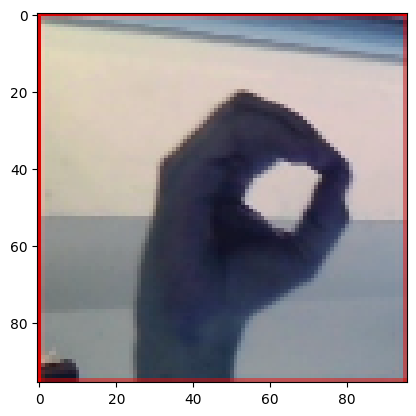

In [12]:
data = []
labels = []

for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (IMAGE_SHAPE_X, IMAGE_SHAPE_Y)) # Resizes every image to be the same size
    image = keras.preprocessing.image.img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = ord(label) - ord('A') # Convert label to numerical value (0-25)
    labels.append([label])

try:
    data = np.array(data, dtype='float') / 255.0
    labels = np.array(labels)
except Exception as e:
    print(f"Error converting data to numpy array: {e}")

print(data.shape)
plt.imshow(data[1])


In [13]:
#Model Params
NUMFILTERS = [32, 64, 128]

In [14]:
#Hyper Params and Model Params
hyperparams = {
    "learningRate" : 1e-5,
    "weightDecay" : .00001,
    "batchSize" : 200,
    "num_epochs" : 20,

    "groupwise?" : True,
    "skipConnections?" : True,
    "NUMFILTERS" : [32, 64, 128]
    

}



In [20]:
dataAugmentation = keras.Sequential([
    keras.layers.Normalization(),
    keras.layers.RandomCrop(90, 90),
    keras.layers.RandomRotation(.2),
    keras.layers.RandomBrightness(.1),
    keras.layers.RandomTranslation(.1, .1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomBrightness(.1)
])

In [21]:
def CreateModel():
    inputs = keras.layers.Input(shape=(IMAGE_SHAPE_X, IMAGE_SHAPE_Y, IMAGE_DEPTH), dtype='float32')
    augmented = dataAugmentation(inputs)
    for elm in hyperparams["NUMFILTERS"]:
        x1 = keras.layers.Conv2D(elm, kernel_size=(3,3), strides=(2,2), padding='same')(augmented)
        x2 = keras.layers.Normalization()(x1)
        x3 = keras.layers.Conv2D(elm, kernel_size=(1,1), strides=(1,1))(x2)
        xSkip = keras.layers.Conv2D(elm, (1,1), strides=(2,2), padding='same')(augmented)
        augmented = keras.layers.Add()([x3, xSkip])
        keras.layers.Normalization()(augmented)
    
    endingPortion = keras.layers.Flatten()(augmented)
    endingPortion = keras.layers.Dense(1024, activation='relu')(endingPortion)

    logits = keras.layers.Dense(28, activation="relu")
    logits = keras.layers.Softmax()(endingPortion)
    model = keras.Model(inputs, logits)
    return model

In [27]:
def runModel(model):
    optimizer = keras.optimizers.Adam(learning_rate=hyperparams["learningRate"], weight_decay=hyperparams["weightDecay"])
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    history = model.fit(x=data, y=labels, batch_size=hyperparams["batchSize"], epochs=hyperparams["num_epochs"])

    return history
    



Epoch 1/20
2/2 [==============================] - 10s 76ms/step - loss: 36.9453 - accuracy: 0.0058
Epoch 2/20
2/2 [==============================] - 0s 55ms/step - loss: 28.8914 - accuracy: 0.0000e+00
Epoch 3/20
2/2 [==============================] - 0s 64ms/step - loss: 25.9448 - accuracy: 0.0000e+00
Epoch 4/20
2/2 [==============================] - 0s 58ms/step - loss: 22.6024 - accuracy: 0.0000e+00
Epoch 5/20
2/2 [==============================] - 0s 57ms/step - loss: 17.9470 - accuracy: 0.0259
Epoch 6/20
2/2 [==============================] - 0s 69ms/step - loss: 15.2542 - accuracy: 0.0173
Epoch 7/20
2/2 [==============================] - 0s 67ms/step - loss: 13.3689 - accuracy: 0.0288
Epoch 8/20
2/2 [==============================] - 0s 66ms/step - loss: 13.8531 - accuracy: 0.0259
Epoch 9/20
2/2 [==============================] - 0s 56ms/step - loss: 13.6542 - accuracy: 0.0317
Epoch 10/20
2/2 [==============================] - 0s 89ms/step - loss: 12.5948 - accuracy: 0.0432
Epoch 

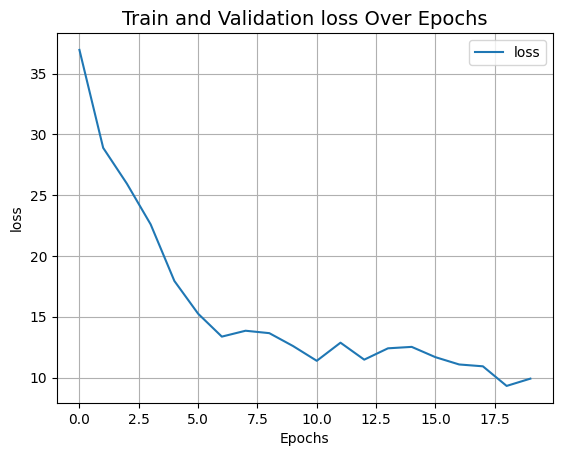

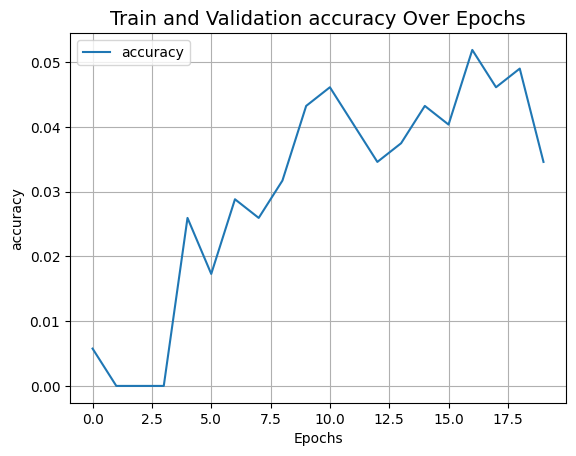

In [34]:
model = CreateModel()
history = runModel(model=model)

# Plot the training and validation loss and accuracy
def plot_history(item):
    plt.plot(history.history[item], label=item)
    #plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [ ]:
#experement = comet_ml.Experiment(
 #   api_key="",
#    project_name="asl-detector",
#    workspace="whyat2"
#)
#experement.log_parameters(hyperparams)


In [ ]:
#experement.log_metric("accuracy", accuracy, step=0)